<font size='6'>Volatility Clustering Generator</font>



Using variational inference applied to time series data, the algorithm non-parametrically chooses a likely number of clusters (latent states) each with distinct <b>mean and covariance</b> parameters allowing computation of a likelihood function for the 3-dimensional point at any time step. The model optimizes the parameters of the clusters to maximize the likelihood of those parameters given the data. 

In order to define what it means to be a good approximation the Kullback-Leibler divergence (KL divergence) is a non-symmetric measure of the difference between two probability distributions 𝑃 and 𝑄, the true posterior and the approximating variational distribution (mean field variational inference - see paper https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf). 

This comes from information theory -- entropy is the average amount of information or "surprise" in the divergence between the distributions. 

$$\large KL(q||p)=E_q\Bigg[\ log\  \frac{q(Z)}{p(Z\  |\ x)}\ \Bigg]$$

In the mean-field approximation, we also assume that the latent states will be partitioned so that each partition is independent. Using KL divergence, we can derive mutually dependent equations (one for each partition) that defines 𝑄 to approximate the posterior distribution. This is done for ease of computation for the iterative approach (expectation-maximization). Maximizing the ELBO log likelihood is equivalent to minimizing the KL divergence between the approximator 𝑄 and the true posterior 𝑃. This is the ELBO constructed with Jensens inequality. 

$$\large log\:p(x | θ) ≥ E_q [log\:p(W, x | θ)] − E_q [log\:q_ν(W)]$$

Borrowing from Physics, in a system with many components that interact, those system interactions are replaced with a single average interaction (a "mean field"). The states' mean/covariances factorize, 

$$\large q(\boldsymbol{\theta}) \approx \prod_{i=1}^n q(\theta_i)$$

$$\large q(\boldsymbol{\mu}, \boldsymbol{\Sigma}) \approx \prod_{i=1}^n q(\mu_i) q(\Sigma_i)$$

This variant of the notebook will sample from the posterior distribution over the parameters of the latent states. This does not make a prediction, instead only <b>describes</b> the historical data and then resamples it using the state-transitioning Markov approach where the probability of resampling a given state should be proportional to it's posterior weight of occurrence in the fitted model.

In [19]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

Testing a small universe of the 10Y Treasury, a Commodity ETF, and Tech ETF. The goal will be time series clustering using variational inference. 

Set num_components to a very high number so the data is fit in a non-parametric way where we need not know the number of clusters in advance. 

In [2]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 99

Create the subset of assets.

In [3]:
m6 = pd.read_csv('./data/assets_m6.csv')
m6_assets = pd.DataFrame()

for sym in assetlist: 
    m6_assets[sym] = m6[m6['symbol'] == sym]['price'].values

Formatting the training data. Absolute value of the 2nd order differencing (differencing twice to get instant variance) from the log price for each asset. View auto-correlation.

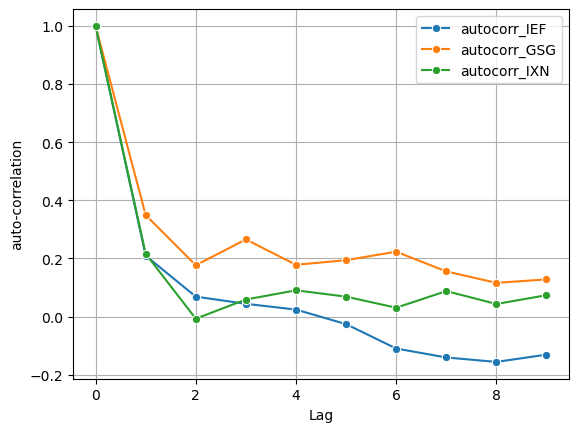

In [14]:
import scipy.stats as stats

# Log volatility absolute value 
m6_subset = m6_assets.copy().apply(np.log).apply(np.diff).apply(np.diff).apply(abs)

# Clean data 
m6_subset = m6_subset.dropna().reset_index().drop(columns='index')

# View auto-correlation decay
decay_func = lambda S, _range: [S.autocorr(lag=Lag) for Lag in _range]
sns.lineplot(data=decay_func(m6_subset['IEF'], range(0, 10)), label='autocorr_IEF', marker='o') 
sns.lineplot(data=decay_func(m6_subset['GSG'], range(0, 10)), label='autocorr_GSG', marker='o')
sns.lineplot(data=decay_func(m6_subset['IXN'], range(0, 10)), label='autocorr_IXN', marker='o')
plt.xlabel('Lag')
plt.ylabel('auto-correlation')
plt.grid(True)
plt.show()

Instantiate a non-parametric clustering model using the dirichlet process. Then, sample 225 separate individual draws from the variational model. This sampling should draw certain states in proportion to their weight in the posterior distribution. 

In [15]:
# Instantiate mixture model 
dpgmm_model = mix.BayesianGaussianMixture(
    n_components=num_components, 
    weight_concentration_prior_type='dirichlet_process',
    n_init=3,
    max_iter=1000)

final state=2


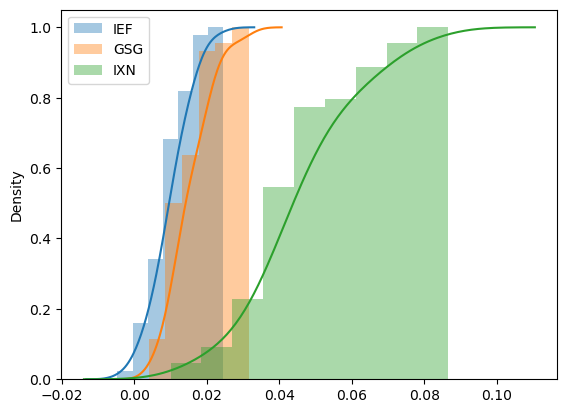

In [16]:
# Fit the model
dpgmm_model.fit(m6_subset)
states = dpgmm_model.predict(m6_subset)

print(f'final state={states[-1]}')

# Sample 225 length batch from the generative model
# Does not reproduce auto-correlation, only proportions of the variational states
samples, y = dpgmm_model.sample(225)

# Create dataframe
df = pd.DataFrame()
df['generated_IEF']=[ s[0] for s in samples ]
df['generated_GSG']=[ s[1] for s in samples ]
df['generated_IXN']=[ s[2] for s in samples ]
df['generated_state'] = y 
   
# Interpret as PDF 
sns.distplot(df[df['generated_state'] == states[-1]]['generated_IEF'].values, hist_kws={'cumulative':True}, kde_kws={'cumulative':True}, label='IEF')
sns.distplot(df[df['generated_state'] == states[-1]]['generated_GSG'].values, hist_kws={'cumulative':True}, kde_kws={'cumulative':True}, label='GSG')
sns.distplot(df[df['generated_state'] == states[-1]]['generated_IXN'].values, hist_kws={'cumulative':True}, kde_kws={'cumulative':True}, label='IXN')
plt.legend()
plt.show()

df.drop(columns=['generated_state'], inplace=True)

# Count the frequency of each latent state 
state_counts = np.zeros(num_components)
for M in y:
  state_counts[M] += 1 

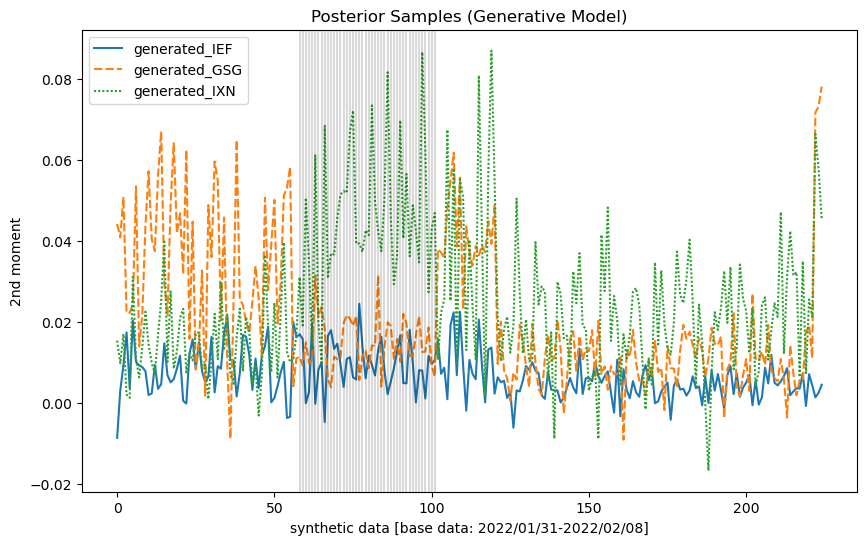

In [20]:
fig,ax = plt.subplots(figsize=(10, 6
                              ))
sns.lineplot(data=df, ax=ax)

for M in range(len(y)): 
  if y[M] == states[-1]:
    ax.axvline(M, color='black', alpha=0.15)

ax.set_title('Posterior Samples (Generative Model)')
ax.set_ylabel('2nd moment')
ax.set_xlabel(f'synthetic data [base data: 2022/01/31-2022/02/08]')
plt.show()

In [18]:
print(state_counts)
print(dpgmm_model.means_[states[-1]])

[ 58.   0.  44.  19. 101.   3.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]
[0.00987401 0.01530153 0.04422   ]
